In this notebook, we use Household Power Consumption dataset, a **multivariate time series dataset** that describes the electricity consumption for a single household over four years December 2006 to November 2010) and observations of power consumption within the household were collected every minute.

Note: observations of power consumption within the household were collected every minute. We can develop an autoregression model for **univariate series of daily power consumption.   

Relate: **MultivariateTimeseries_HouseHold_forecast**.

In [19]:
# acf and pacf plots of total power usage
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf

In [10]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6] 
    # restructure into windows of weekly data 
    train = np.array(np.split(train, len(train)/7)) 
    test = np.array(np.split(test, len(test)/7)) 
    return train, test

# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week 
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

In [28]:
# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [32]:
dataset.shape

(1442, 8)

In [37]:
dataset.iloc[:,0]

datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
                ...   
2010-11-22    2041.536
2010-11-23    1577.536
2010-11-24    1796.248
2010-11-25    1431.164
2010-11-26    1488.104
Name: Global_active_power, Length: 1442, dtype: float64

First, the history data comprised of weeks of prior observations must be converted into a univariate time series of daily power consumption

In [30]:
# split into train and test
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)

series[:10]

array([3390.46 , 2203.826, 1666.194, 2225.748, 1723.288, 2341.338,
       4773.386, 2550.012, 2743.12 , 3934.11 ])

In [34]:
print('train set ',len(series))

train set  1113


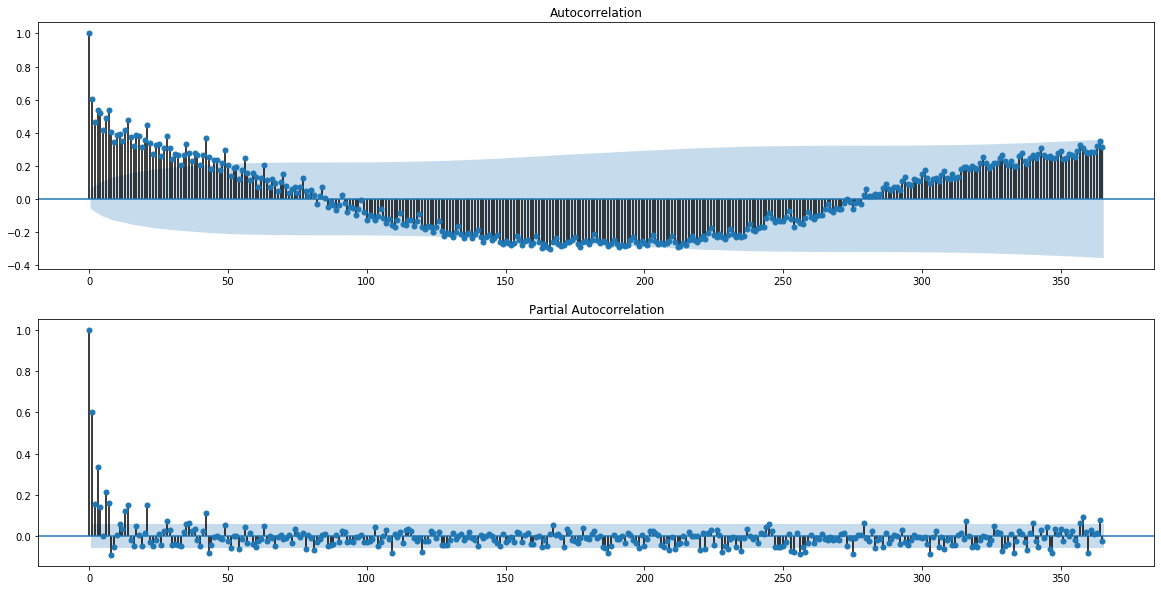

In [15]:
# plots
plt.figure(figsize=(20,10))
lags = 365
# acf
axis = plt.subplot(2, 1, 1) 
plot_acf(series, ax=axis, lags=lags) # pacf
axis = plt.subplot(2, 1, 2) 
plot_pacf(series, ax=axis, lags=lags) # show plot
plt.show()

We might see some significant lag observations at one year out. Let zoom in the plot and change the number of lag observations from 365 to 50.

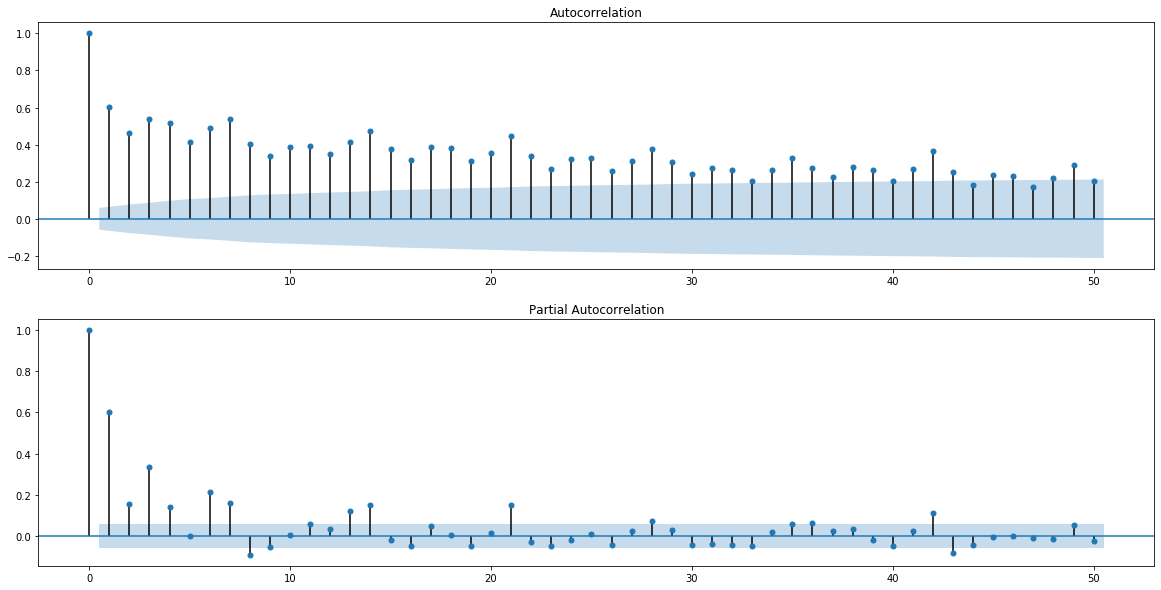

In [17]:

lags = 50
plt.figure(figsize=(20,10))
# acf
axis = plt.subplot(2, 1, 1) 
plot_acf(series, ax=axis, lags=lags) # pacf
axis = plt.subplot(2, 1, 2) 
plot_pacf(series, ax=axis, lags=lags) # show plot
plt.show()

**This pattern is comprised of two elements:**
􏰀 **ACF:** A large number of significant lag observations that slowly degrade as the lag increases.
􏰀 **PACF:** A few significant lag observations that abruptly drop as the lag increases.   

The ACF plot indicates that there is a strong autocorrelation component, whereas the PACF plot indicates that this component is distinct for the first approximately seven lag observations. This suggests that a good starting model would be an AR(7); that is an autoregression model with seven lag observations used as input.

In [25]:

# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6) 
    return yhat

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
# calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
            
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1])) 
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

    
# evaluate a single model
def evaluate_model(model_func, train, test): 
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week 
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week 
        history.append(test[i, :])
        
    predictions = np.array(predictions)
      # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
    return score, scores

arima: [381.637] 393.8, 398.9, 357.0, 377.2, 393.8, 306.1, 432.2


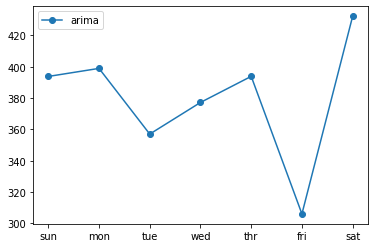

In [27]:
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model

days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
for name, func in models.items():
  # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
      # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(days, scores, marker='o', label=name) # show plot
plt.legend()
plt.show()

We can see that the model achieves the overall RMSE of about 381 kilowatts. This model has skill when compared to naive forecast models, such as a model that forecasts the week ahead using observations from the same time one year ago that achieved an overall RMSE of about 465 kilowatts.